# Dataset

## Extract Dataset

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install pycuda
!apt-get install -y libcusparse8.0 libcudnn7=7.6.5.32-1+cuda10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.2 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661975 sha256=fbfd5d1dfafb680dd345eb08630667541e9861a6ce0d703454d568374dfc2e12
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69855 sha256=517bc050be3a147edbacc883971e0d8af16b73eb50788da8ae02d0d045ca8547
  Stored in directory: /root/.cache/pip/wheels/19/0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/DL'

/content/drive/MyDrive/DL


## Load and join all the datasets for Vent

In [ ]:
# Load Vent dataset
import pandas as pd
vents = pd.read_csv('vents.csv')
vents.head()

In [ ]:
# Load emotion_categories dataset
emotion_categories = pd.read_csv('emotion_categories.csv')
emotion_categories

In [ ]:
# Load emotions dataset
emotions = pd.read_csv('emotions.csv')
emotions

In [ ]:
# Join emotion_categories and emotions on the common column 'id' and 'emotion_category_id'
merged_df = pd.merge(emotion_categories, emotions,  how='inner',left_on='id', right_on='emotion_category_id')

# Print the merged dataframe
merged_df

In [ ]:
# Extract category == "Feelings"
label_feelings_df = merged_df[merged_df['name_x'].str.contains('Feelings')]
label_feelings_df

In [ ]:
#select the specific emotion id with the emotion name
feeling_label = label_feelings_df[['id_y', 'name_y']]
feeling_label.head()

,id_y,name_y
218,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Hungry
219,2ca41655-7436-4a50-81b4-8d209c5df984,Confident
220,a4dfef40-f02f-4ddc-9dfa-e156e4375346,Hurt
221,7bdc7c69-4263-434f-9322-507bcafba2da,☘FESTIVE ☘
222,8c5cc6c1-46fd-4a73-8899-9cda247755cb,😇 HONEST 😇


In [ ]:
# Join Feeling_label with vent to get text along with specific emotion
merged_feeling_text_df = pd.merge(feeling_label, vents,  how='inner',left_on='id_y', right_on='emotion_id')
merged_feeling_text_df.head()

,id_y,name_y,emotion_id,user_id,created_at,reactions,text
0,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Hungry,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,3d84e6de-51dd-46dd-8eb1-7417cdcbb41c,2015-12-03 03:09:30.627,0.0,Omg I eat too much I need to stop fr
1,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Hungry,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,3d84e6de-51dd-46dd-8eb1-7417cdcbb41c,2015-11-21 16:26:33.627,4.0,Im starving.... Literally
2,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Hungry,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,3d84e6de-51dd-46dd-8eb1-7417cdcbb41c,2015-11-17 16:24:22.192,6.0,I always have a snack before my meals cause I ...
3,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Hungry,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,bde48414-c86e-398f-bfd1-1c00c0f941d4,2016-07-30 19:40:43.437,0.0,UGHHHHHH
4,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Hungry,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,cde621f6-965e-491d-a5c4-92b0247994bc,2016-01-21 11:27:13.498,3.0,CRAVING FOR PIZZA AND SIOMAI. 😣😣


In [ ]:
merged_feeling_text_df.shape

(4359045, 7)

## Vent Data Cleaning, binarized and Sampling

In [ ]:
import re

In [ ]:
# Remove comments with unwanted patterns (single character space, special character, emojis etc.)
# Function to remove emojis
def remove_emojis(data):
    emoj = re.compile("["
                      u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      u"\U00002500-\U00002BEF"  # chinese characters
                      u"\U00002702-\U000027B0"
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      u"\U0001f926-\U0001f937"
                      u"\U00010000-\U0010ffff"
                      u"\u2640-\u2642"
                      u"\u2600-\u2B55"
                      u"\u200d"
                      u"\u23cf"
                      u"\u23e9"
                      u"\u231a"
                      u"\ufe0f"  # dingbats
                      u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

# Removing single character spaces, special characters, and emojis
#merged_feeling_text_df['text'] = merged_feeling_text_df['text'].apply(lambda x: re.sub(r'\W|\b\w\b', ' ', x)) # Remove single character and special characters
# Clean text data
def clean_text(text):
    # Remove non-ascii characters
    text = text.encode("ascii", errors="ignore").decode()
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text, flags=re.MULTILINE)
    # Remove all the special characters
    text = ' '.join(re.findall(r'\b\w+\b', text))
    # Single character removal
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Remove empty or only space-containing cells
    if text.strip() == "":
        return None

    # Substitute overlong sequences of identical characters (more than 2)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    return text

merged_feeling_text_df['text'] = merged_feeling_text_df['text'].apply(remove_emojis) # Remove emojis
merged_feeling_text_df['text'] = merged_feeling_text_df['text'].apply(clean_text)
merged_feeling_text_df = merged_feeling_text_df[merged_feeling_text_df['text'].notna()]


# Drop null values
merged_feeling_text_df = merged_feeling_text_df.dropna(subset=['text'])

# Print the updated dataframe
print(merged_feeling_text_df.head())

                                   id_y  name_y  \
0  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  Hungry   
1  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  Hungry   
2  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  Hungry   
3  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  Hungry   
4  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  Hungry   

                             emotion_id                               user_id  \
0  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  3d84e6de-51dd-46dd-8eb1-7417cdcbb41c   
1  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  3d84e6de-51dd-46dd-8eb1-7417cdcbb41c   
2  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  3d84e6de-51dd-46dd-8eb1-7417cdcbb41c   
3  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  bde48414-c86e-398f-bfd1-1c00c0f941d4   
4  c0dd0bcf-81c3-48d8-b75b-e150c24162bc  cde621f6-965e-491d-a5c4-92b0247994bc   

                created_at  reactions  \
0  2015-12-03 03:09:30.627        0.0   
1  2015-11-21 16:26:33.627        4.0   
2  2015-11-17 16:24:22.192        6.0   
3  2016-07-30 19:40:43.437        0.0   
4

In [ ]:
merged_feeling_text_df['text'] = merged_feeling_text_df['text'].str.lower()
merged_feeling_text_df['text'] = merged_feeling_text_df['text'].apply(lambda x: re.sub(r'\W+', ' ', x))

In [ ]:
# Convert all the non-guilty label into "Non-guilty"
merged_feeling_text_df['name_y'] = merged_feeling_text_df['name_y'].apply(lambda x: 'Non-guilty' if x != 'Guilty' else 'Guilty')

# Print the updated dataframe
merged_feeling_text_df.head()

,id_y,name_y,emotion_id,user_id,created_at,reactions,text
0,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,3d84e6de-51dd-46dd-8eb1-7417cdcbb41c,2015-12-03 03:09:30.627,0.0,Omg eat too much need to stop fr
1,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,3d84e6de-51dd-46dd-8eb1-7417cdcbb41c,2015-11-21 16:26:33.627,4.0,Im starving Literally
2,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,3d84e6de-51dd-46dd-8eb1-7417cdcbb41c,2015-11-17 16:24:22.192,6.0,always have snack before my meals cause ...
3,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,bde48414-c86e-398f-bfd1-1c00c0f941d4,2016-07-30 19:40:43.437,0.0,UGHHHHHH
4,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,cde621f6-965e-491d-a5c4-92b0247994bc,2016-01-21 11:27:13.498,3.0,CRAVING FOR PIZZA AND SIOMAI


In [ ]:
# Show the number of Guilty vs. Non-guilty
merged_feeling_text_df['name_y'].value_counts()

Non-guilty    4224611
Guilty         134434
Name: name_y, dtype: int64

In [ ]:
# Separate the dataframe into 'Guilty' and 'Non-guilty' dataframes
guilty_df = merged_feeling_text_df[merged_feeling_text_df['name_y'] == 'Guilty']
non_guilty_df = merged_feeling_text_df[merged_feeling_text_df['name_y'] == 'Non-guilty']

# Sample from 'Non-guilty' dataframe
non_guilty_sample_df = non_guilty_df.sample(n=len(guilty_df), random_state=1)

# Sample 1200 texts from 'guilty' dataframe
guilty_sample_1200 = guilty_df.sample(n=1200, random_state=1)

# Sample 1048 text from non_guilty_sample_df
non_guilty_sample_1048 = non_guilty_sample_df.sample(n=1048, random_state=1)

# Concatenate the sampled 'Non-guilty' dataframe with the 'Guilty' dataframe
balanced_df = pd.concat([guilty_sample_1200, non_guilty_sample_1048])

# Print the balanced dataframe
balanced_df.head()

,id_y,name_y,emotion_id,user_id,created_at,reactions,text
523430,42935e4e-2c07-4bda-8377-d74d4cf817d7,Guilty,42935e4e-2c07-4bda-8377-d74d4cf817d7,1b9773c3-139d-3a03-a431-c041890e531a,2016-06-07 20:05:18.181,1.0,cannot focus on anything and feel like ...
527777,42935e4e-2c07-4bda-8377-d74d4cf817d7,Guilty,42935e4e-2c07-4bda-8377-d74d4cf817d7,595a0ec8-78e6-3834-949c-e6142bbc4625,2016-05-12 03:10:29.347,4.0,feel dumb
496512,42935e4e-2c07-4bda-8377-d74d4cf817d7,Guilty,42935e4e-2c07-4bda-8377-d74d4cf817d7,b67c9ff6-2775-4060-9468-66e1870d485c,2016-06-05 19:33:46.025,12.0,if you re tired of these fuckboys let lesbi...
548321,42935e4e-2c07-4bda-8377-d74d4cf817d7,Guilty,42935e4e-2c07-4bda-8377-d74d4cf817d7,baab0bcc-766b-471f-b564-00cef5d066a1,2016-06-06 20:37:07.039,2.0,
529424,42935e4e-2c07-4bda-8377-d74d4cf817d7,Guilty,42935e4e-2c07-4bda-8377-d74d4cf817d7,3d175b6d-1260-4d8a-a55d-c4b8123c3211,2016-07-22 01:35:55.074,5.0,feel so bad for eating meals today sc...


In [ ]:
merged_feeling_text_df.to_csv('preprocessed.csv')

In [ ]:
merged_feeling_text_df.head()

,id_y,name_y,emotion_id,user_id,created_at,reactions,text
0,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,3d84e6de-51dd-46dd-8eb1-7417cdcbb41c,2015-12-03 03:09:30.627,0.0,Omg eat too much need to stop fr
1,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,3d84e6de-51dd-46dd-8eb1-7417cdcbb41c,2015-11-21 16:26:33.627,4.0,Im starving Literally
2,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,3d84e6de-51dd-46dd-8eb1-7417cdcbb41c,2015-11-17 16:24:22.192,6.0,always have snack before my meals cause ...
3,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,bde48414-c86e-398f-bfd1-1c00c0f941d4,2016-07-30 19:40:43.437,0.0,UGHHHHHH
4,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,Non-guilty,c0dd0bcf-81c3-48d8-b75b-e150c24162bc,cde621f6-965e-491d-a5c4-92b0247994bc,2016-01-21 11:27:13.498,3.0,CRAVING FOR PIZZA AND SIOMAI


## read dataset

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/DL'

/content/drive/MyDrive/DL


In [4]:
train = pd.read_csv('train_data.csv',encoding='utf-8')
test = pd.read_csv('test_data.csv',encoding='utf-8')

In [5]:
train.head()

,text,label
0,_user_reference_ 1 what your name username rei...,1
1,those who try to stop racism are often the mos...,1
2,the plus side to being sick on the weekend you...,1
3,binaural beats people listen to them when goin...,1
4,sleepyy sleepy slepy,1


In [6]:
label_counts = train['label'].value_counts()
label_counts

1    106791
0    106791
Name: label, dtype: int64

In [7]:
label_counts = test['label'].value_counts()
label_counts

1    837011
0     26658
Name: label, dtype: int64

In [5]:
X_train,y_train=train['text'],train['label']
X_test,y_test=test['text'],test['label']

# tf-idf+LR

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.utils import resample
# Separate the majority and minority classes in the training set
majority_class = X_train[y_train == 1]
minority_class = X_train[y_train == 0]

# Undersample the majority class in the training set
undersampled_majority = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Combine the undersampled majority class with the minority class in the training set
undersampled_X_train = pd.concat([undersampled_majority, minority_class])
undersampled_y_train = pd.concat([pd.Series([1]*len(undersampled_majority)), pd.Series([0]*len(minority_class))])

In [ ]:
undersampled_X_train.shape

(215418,)

In [ ]:
X_train[0]

'Omg   eat too much   need to stop fr'

In [ ]:
X_test.shape

(871809,)

In [9]:
#Convert the raw text data into numerical features using TF-IDF vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
X_train_tfidf.shape

(215418, 82334)

In [10]:
model = LogisticRegression(penalty='l2',solver='saga')
model.fit(X_train_tfidf, y_train)

LogisticRegression(solver='saga')

In [12]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_train_tfidf)
report = classification_report(y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77    106791
           1       0.76      0.79      0.77    106791

    accuracy                           0.77    213582
   macro avg       0.77      0.77      0.77    213582
weighted avg       0.77      0.77      0.77    213582



In [ ]:
y_pred = model.predict(X_test_tfidf)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.09      0.72      0.15     26725
           1       0.99      0.76      0.86    845084

    accuracy                           0.75    871809
   macro avg       0.54      0.74      0.50    871809
weighted avg       0.96      0.75      0.84    871809



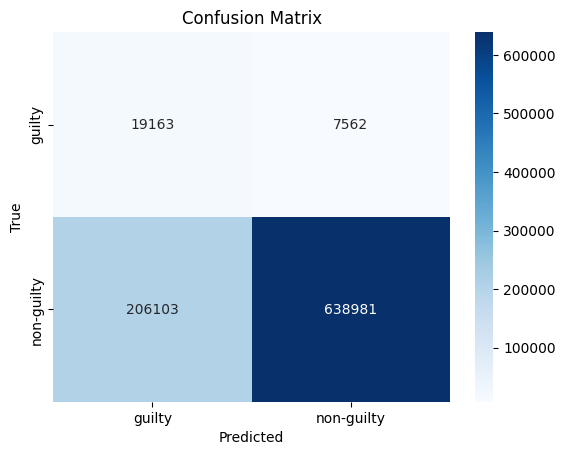

In [ ]:
#confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_labels = ['guilty', 'non-guilty']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels, title, and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.show()

# BiLSTM

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense,Dropout

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from sklearn.utils import resample
# Separate the majority and minority classes in the training set
majority_class = X_train[y_train == 1]
minority_class = X_train[y_train == 0]

# Undersample the majority class in the training set
undersampled_majority = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Combine the undersampled majority class with the minority class in the training set
undersampled_X_train = pd.concat([undersampled_majority, minority_class])
undersampled_y_train = pd.concat([pd.Series([1]*len(undersampled_majority)), pd.Series([0]*len(minority_class))])

In [12]:
# Tokenize and pad sequences
max_sequence_length = 100  # Max sequence length to consider
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

### orginal-finished

In [17]:
# Build the LSTM model
embedding_dim = 100  # Embedding dimension
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

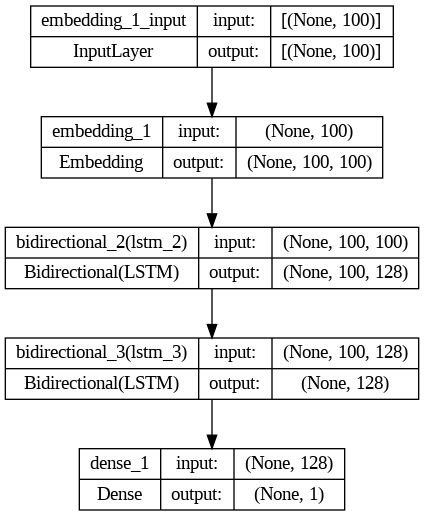

In [18]:
from tensorflow.keras.utils import plot_model
# Visualize the model structure
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

model.fit(X_train_padded, undersampled_y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

Epoch 1/10
6732/6732 [==============================] - 334s 49ms/step - loss: 0.5423 - accuracy: 0.7177 - val_loss: 0.4968 - val_accuracy: 0.7647
Epoch 2/10
6732/6732 [==============================] - 284s 42ms/step - loss: 0.4800 - accuracy: 0.7649 - val_loss: 0.4688 - val_accuracy: 0.7795
Epoch 3/10
6732/6732 [==============================] - 282s 42ms/step - loss: 0.4324 - accuracy: 0.7955 - val_loss: 0.5169 - val_accuracy: 0.7432
Epoch 4/10
6732/6732 [==============================] - 287s 43ms/step - loss: 0.3776 - accuracy: 0.8262 - val_loss: 0.5916 - val_accuracy: 0.7215
Epoch 5/10
6732/6732 [==============================] - 297s 44ms/step - loss: 0.3239 - accuracy: 0.8524 - val_loss: 0.6348 - val_accuracy: 0.7278
Epoch 6/10
6732/6732 [==============================] - 281s 42ms/step - loss: 0.2802 - accuracy: 0.8729 - val_loss: 0.6973 - val_accuracy: 0.7380
Epoch 7/10
6732/6732 [==============================] - 281s 42ms/step - loss: 0.2446 - accuracy: 0.8892 - val_loss: 0

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, batch_size=batch_size)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

27245/27245 [==============================] - 189s 7ms/step - loss: 1.0137 - accuracy: 0.7281
Test Loss: 1.0136761665344238
Test Accuracy: 0.7280539870262146


### change the batch size

In [28]:
# modify the batch size to 16
epochs = 10  # Number of training epochs
batch_size = 64  # Batch size

model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

Epoch 1/10
3338/3338 [==============================] - 155s 46ms/step - loss: 0.4014 - accuracy: 0.8212 - val_loss: 0.6196 - val_accuracy: 0.7061
Epoch 2/10
3338/3338 [==============================] - 112s 34ms/step - loss: 0.3955 - accuracy: 0.8250 - val_loss: 0.6082 - val_accuracy: 0.7264
Epoch 3/10
3338/3338 [==============================] - 108s 32ms/step - loss: 0.3896 - accuracy: 0.8278 - val_loss: 0.6036 - val_accuracy: 0.7295
Epoch 4/10
3338/3338 [==============================] - 106s 32ms/step - loss: 0.3845 - accuracy: 0.8298 - val_loss: 0.5830 - val_accuracy: 0.7525
Epoch 5/10
3338/3338 [==============================] - 106s 32ms/step - loss: 0.3798 - accuracy: 0.8322 - val_loss: 0.6440 - val_accuracy: 0.7284
Epoch 6/10
3338/3338 [==============================] - 105s 32ms/step - loss: 0.3755 - accuracy: 0.8346 - val_loss: 0.6274 - val_accuracy: 0.7365
Epoch 7/10
3338/3338 [==============================] - 105s 32ms/step - loss: 0.3714 - accuracy: 0.8362 - val_loss: 0

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, batch_size=batch_size)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

13495/13495 [==============================] - 72s 5ms/step - loss: 0.5399 - accuracy: 0.7666
Test Loss: 0.5398588180541992
Test Accuracy: 0.7665945887565613


### add a dropout layer-finished

In [ ]:
# add a dropout layer
# Build the LSTM model
embedding_dim = 100  # Embedding dimension
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# modify the batch size to 16
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

Epoch 1/10
6675/6675 [==============================] - 345s 50ms/step - loss: 0.5388 - accuracy: 0.7225 - val_loss: 0.4748 - val_accuracy: 0.8043
Epoch 2/10
6675/6675 [==============================] - 277s 41ms/step - loss: 0.4821 - accuracy: 0.7639 - val_loss: 0.5293 - val_accuracy: 0.7236
Epoch 3/10
6675/6675 [==============================] - 277s 42ms/step - loss: 0.4382 - accuracy: 0.7927 - val_loss: 0.5483 - val_accuracy: 0.7401
Epoch 4/10
6675/6675 [==============================] - 273s 41ms/step - loss: 0.3915 - accuracy: 0.8190 - val_loss: 0.5922 - val_accuracy: 0.7325
Epoch 5/10
6675/6675 [==============================] - 273s 41ms/step - loss: 0.3444 - accuracy: 0.8440 - val_loss: 0.6649 - val_accuracy: 0.7210
Epoch 6/10
6675/6675 [==============================] - 272s 41ms/step - loss: 0.3022 - accuracy: 0.8646 - val_loss: 0.7900 - val_accuracy: 0.6759
Epoch 7/10
6675/6675 [==============================] - 274s 41ms/step - loss: 0.2677 - accuracy: 0.8806 - val_loss: 0

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, batch_size=batch_size)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

26990/26990 [==============================] - 186s 7ms/step - loss: 0.9874 - accuracy: 0.7005
Test Loss: 0.9874386191368103
Test Accuracy: 0.700542688369751


### use regularization method

In [13]:
# add a dropout layer
# Build the LSTM model
embedding_dim = 100  # Embedding dimension
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.05))))
#model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64,kernel_regularizer=regularizers.l2(0.05))))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# modify the batch size to 16
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

Epoch 1/10
6675/6675 [==============================] - 365s 53ms/step - loss: 0.7503 - accuracy: 0.7033 - val_loss: 0.5178 - val_accuracy: 0.7564
Epoch 2/10
6675/6675 [==============================] - 294s 44ms/step - loss: 0.5476 - accuracy: 0.7398 - val_loss: 0.7213 - val_accuracy: 0.6155
Epoch 3/10
6675/6675 [==============================] - 291s 44ms/step - loss: 0.5130 - accuracy: 0.7591 - val_loss: 0.5426 - val_accuracy: 0.7425
Epoch 4/10
6675/6675 [==============================] - 289s 43ms/step - loss: 0.4946 - accuracy: 0.7692 - val_loss: 0.5099 - val_accuracy: 0.7774
Epoch 5/10
6675/6675 [==============================] - 287s 43ms/step - loss: 0.4776 - accuracy: 0.7804 - val_loss: 0.5117 - val_accuracy: 0.7409
Epoch 6/10
6675/6675 [==============================] - 289s 43ms/step - loss: 0.4662 - accuracy: 0.7878 - val_loss: 0.6519 - val_accuracy: 0.6691
Epoch 7/10
6675/6675 [==============================] - 289s 43ms/step - loss: 0.4575 - accuracy: 0.7921 - val_loss: 0

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, batch_size=batch_size)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

26990/26990 [==============================] - 195s 7ms/step - loss: 0.4950 - accuracy: 0.7700
Test Loss: 0.4950246810913086
Test Accuracy: 0.7700368762016296


# biLSTM+CNN

## orginal

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Multiply, Activation

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

# Define the model
model = Sequential()

# Input Representation
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))

# BiLSTM Layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# CNN Layer
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

# Attention Mechanism
attention_size = 64
attention_weights = Dense(attention_size, activation='tanh')(model.output)
attention_weights = Dense(1)(attention_weights)
attention_weights = Activation('softmax')(attention_weights)
attention_output = Multiply()([model.output, attention_weights])

# Fully Connected Layers
model.add(Dense(64, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Create the model with attention layer
model = Model(inputs=model.input, outputs=model.output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2_input (InputLay  [(None, 100)]            0         
 er)                                                             
                                                                 
 embedding_2 (Embedding)     (None, 100, 100)          6983500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 128)         84480     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

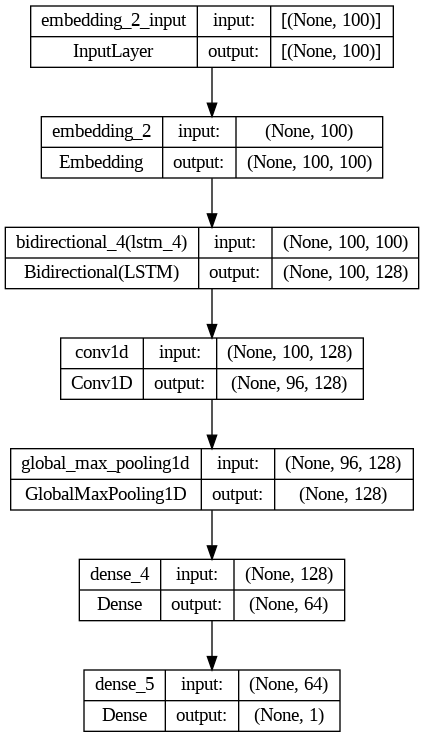

In [20]:
from tensorflow.keras.utils import plot_model
# Visualize the model structure
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
# modify the batch size to 16
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

model.fit(X_train_padded, undersampled_y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

Epoch 1/10
6732/6732 [==============================] - 257s 37ms/step - loss: 0.5322 - accuracy: 0.7253 - val_loss: 0.5122 - val_accuracy: 0.7608
Epoch 2/10
6732/6732 [==============================] - 193s 29ms/step - loss: 0.4723 - accuracy: 0.7707 - val_loss: 0.5016 - val_accuracy: 0.7705
Epoch 3/10
6732/6732 [==============================] - 190s 28ms/step - loss: 0.4170 - accuracy: 0.8046 - val_loss: 0.5218 - val_accuracy: 0.7486
Epoch 4/10
6732/6732 [==============================] - 188s 28ms/step - loss: 0.3542 - accuracy: 0.8381 - val_loss: 0.5778 - val_accuracy: 0.7313
Epoch 5/10
6732/6732 [==============================] - 188s 28ms/step - loss: 0.2946 - accuracy: 0.8670 - val_loss: 0.6941 - val_accuracy: 0.7087
Epoch 6/10
6732/6732 [==============================] - 188s 28ms/step - loss: 0.2480 - accuracy: 0.8873 - val_loss: 0.7125 - val_accuracy: 0.7549
Epoch 7/10
6732/6732 [==============================] - 186s 28ms/step - loss: 0.2142 - accuracy: 0.9034 - val_loss: 0

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test, batch_size=batch_size)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

27245/27245 [==============================] - 127s 5ms/step - loss: 1.6727 - accuracy: 0.6646
Test Loss: 1.672655701637268
Test Accuracy: 0.6645973920822144


## early stopping

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

# Define the model
model = Sequential()

# Input Representation
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))

# BiLSTM Layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))

#Dropout
model.add(Dropout(0.5))

# CNN Layer
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

# Attention Mechanism
attention_size = 64
attention_weights = Dense(attention_size, activation='tanh')(model.output)
attention_weights = Dense(1)(attention_weights)
attention_weights = Activation('softmax')(attention_weights)
attention_output = Multiply()([model.output, attention_weights])

# Fully Connected Layers
model.add(Dense(64, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Create the model with attention layer
model = Model(inputs=model.input, outputs=model.output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2_input (InputLay  [(None, 100)]            0         
 er)                                                             
                                                                 
 embedding_2 (Embedding)     (None, 100, 100)          7890000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 128)         84480     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0   

In [ ]:
epochs = 6  # Number of training epochs
batch_size = 32  # Batch size

model.fit(X_train_padded, undersampled_y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

Epoch 1/10
6732/6732 [==============================] - 236s 34ms/step - loss: 0.5363 - accuracy: 0.7230 - val_loss: 0.5064 - val_accuracy: 0.7871
Epoch 2/10
6732/6732 [==============================] - 192s 29ms/step - loss: 0.4785 - accuracy: 0.7672 - val_loss: 0.5278 - val_accuracy: 0.7237
Epoch 3/10
6732/6732 [==============================] - 189s 28ms/step - loss: 0.4282 - accuracy: 0.7983 - val_loss: 0.5250 - val_accuracy: 0.7700
Epoch 4/10
6732/6732 [==============================] - 190s 28ms/step - loss: 0.3753 - accuracy: 0.8271 - val_loss: 0.6047 - val_accuracy: 0.7291
Epoch 5/10
6732/6732 [==============================] - 191s 28ms/step - loss: 0.3261 - accuracy: 0.8522 - val_loss: 0.6109 - val_accuracy: 0.7325
Epoch 6/10
6732/6732 [==============================] - 219s 33ms/step - loss: 0.2854 - accuracy: 0.8710 - val_loss: 0.6381 - val_accuracy: 0.7356
Epoch 7/10
6732/6732 [==============================] - 189s 28ms/step - loss: 0.2528 - accuracy: 0.8856 - val_loss: 0

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test, batch_size=batch_size)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

27245/27245 [==============================] - 129s 5ms/step - loss: 0.9965 - accuracy: 0.6964
Test Loss: 0.9964879751205444
Test Accuracy: 0.69638991355896


## l2 regularization

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Multiply, Activation

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

# Define the model
model = Sequential()

# Input Representation
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))

# BiLSTM Layer with L2 regularization
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.05))))

# CNN Layer
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

# Attention Mechanism
attention_size = 64
attention_weights = Dense(attention_size, activation='tanh')(model.output)
attention_weights = Dense(1)(attention_weights)
attention_weights = Activation('softmax')(attention_weights)
attention_output = Multiply()([model.output, attention_weights])

# Fully Connected Layers with L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.05)))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Create the model with attention layer
model = Model(inputs=model.input, outputs=model.output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4_input (InputLay  [(None, 100)]            0         
 er)                                                             
                                                                 
 embedding_4 (Embedding)     (None, 100, 100)          6983500   
                                                                 
 bidirectional_6 (Bidirectio  (None, 100, 128)         84480     
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                           

In [26]:
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

Epoch 1/10
6675/6675 [==============================] - 241s 36ms/step - loss: 0.6813 - accuracy: 0.7142 - val_loss: 0.4138 - val_accuracy: 0.8388
Epoch 2/10
6675/6675 [==============================] - 193s 29ms/step - loss: 0.5188 - accuracy: 0.7506 - val_loss: 0.4969 - val_accuracy: 0.7671
Epoch 3/10
6675/6675 [==============================] - 192s 29ms/step - loss: 0.4978 - accuracy: 0.7654 - val_loss: 0.4032 - val_accuracy: 0.8276
Epoch 4/10
6675/6675 [==============================] - 191s 29ms/step - loss: 0.4821 - accuracy: 0.7758 - val_loss: 0.5289 - val_accuracy: 0.7386
Epoch 5/10
6675/6675 [==============================] - 191s 29ms/step - loss: 0.4691 - accuracy: 0.7843 - val_loss: 0.6380 - val_accuracy: 0.6968
Epoch 6/10
6675/6675 [==============================] - 192s 29ms/step - loss: 0.4560 - accuracy: 0.7916 - val_loss: 0.6945 - val_accuracy: 0.6504
Epoch 7/10
6675/6675 [==============================] - 190s 29ms/step - loss: 0.4449 - accuracy: 0.7977 - val_loss: 0

In [27]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test, batch_size=batch_size)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

26990/26990 [==============================] - 134s 5ms/step - loss: 0.5131 - accuracy: 0.7636
Test Loss: 0.5130504369735718
Test Accuracy: 0.7636293768882751
